# 1. Solution to Intertemporal Portfolio Choice Problem
This notebook contains my solution to one configuration of [Merton's intertemporal portfolio choice problem](https://en.wikipedia.org/wiki/Merton%27s_portfolio_problem). I used Deep Reinforcement Learning to estimate a policy that selects the risk allocation and consumption of an agent over 10 periods in a stochastic environment. The original problem is famous in part because the continuous-time formulation has a closed form solution. However the continuous-time solution requires several assumptions about markets that are unrealistic in practice and relaxing these assumptions significantly increases the difficulty of the problem. Deep Reinforcement Learning offers an alternative methodology for solving optimal control problems.  My model demonstrates that RL agents can learn to solve the portfolio choice problem in discrete time.

### Using this notebook
To load the saved model coefficients and evaluate its performance, load the required packages in Section 2 and then skip to Section 4 of this notebook. Section 3 contains the code I used to estimate the model.

# 2. Load required packages
This solution was estimated using the TD3 model from OpenAI's [stable_baselines3](https://stable-baselines.readthedocs.io/en/master/) package.

In [2]:
from stable_baselines3 import TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import gym
from gym import spaces
import pandas as pd
import numpy as np
from PortfolioChoice import PortfolioChoice

# create and check environment
env = PortfolioChoice()
check_env(env)

c:\Users\paulw\Anaconda3\envs\openai\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# 3. Estimate model
Since it is impossible to comprehensively explore the hyper-parameter space, I experimented to see which hyper-parameters had the greatest impact on model training and focused development on those. I found the solution was particularly sensitive to a few hyper-parameters, the most important of these was the policy_delay. This parameter delays policy model training until after each policy has been run for 100 steps - or in this case 10 episodes. This ensures that the policy doesn't change until it has seen multiple random asset return draws which significantly improved the stability of model training. Additionally setting the buffer size to 30,000 also helped stabilize training by limiting how much history was retained during training. Finally reducing the policy network size and increasing the q-value network depth improved training time and stability.

In [ ]:
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5)*np.ones(n_actions))
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[256, 128, 64, 32]))
td3_model = TD3(MlpPolicy, env, verbose=1, action_noise=action_noise, policy_kwargs=policy_kwargs, buffer_size=30000, gamma=1, learning_starts=128, train_freq=(1,"episode"), batch_size=128, policy_delay=100)
td3_model.learn(total_timesteps=300000)
td3_model.save("PortfolioChoice_solution")

# 4. Evaluate model
Given the configuration of environment parameters the optimal continuous solutions are a constant risk allocation and a consumption rate that increases monotonically over time and accelerates as the final period approaches. Although my RL agent was necessarily built using discrete-time data, it consistently provides policies that closely track these continuous-time optimal policies.

c:\Users\paulw\Anaconda3\envs\openai\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


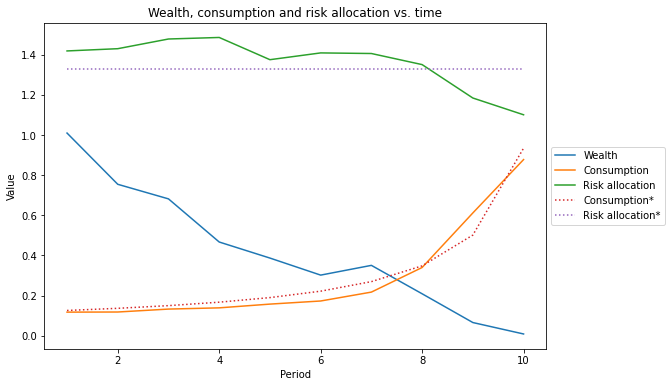

In [54]:
import matplotlib.pyplot as plt

solution_model = TD3.load("PortfolioChoice_solution")
env = PortfolioChoice()
obs = env.reset()
results = []

for n in range(10):
    action, _states = solution_model.predict(obs)
    obs, rewards, dones, info = env.step(action,0.1)
    risk_alloc = (action[0])*2+1
    consumption = (action[1]+1)/2
    optimal_risk = 1.33
    optimal_cons = 0.05*(1 + (0.05*.1 - 1)*np.exp(-0.05*(10-n)))**-1
    wealth = obs[0]
    time = obs[1]*10
    results.append([time, wealth, consumption, risk_alloc, optimal_cons, optimal_risk])

results = pd.DataFrame(results)
results.columns = ['Time','Wealth', 'Consumption', 'Risk allocation', 'Consumption*', 'Risk allocation*']

fig = plt.figure(figsize=(9,6))
plt.plot(results['Time'],results[['Wealth', 'Consumption', 'Risk allocation']])
plt.plot(results['Time'],results[['Consumption*', 'Risk allocation*']], linestyle='dotted')
plt.title("Wealth, consumption and risk allocation vs. time")
plt.xlabel("Period")
plt.ylabel("Value")
plt.legend(loc='center left',labels=['Wealth', 'Consumption', 'Risk allocation', 'Consumption*', 'Risk allocation*'], bbox_to_anchor=(1, 0.5))
plt.show()